<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Final Project</div>
<div style="text-align: right">Group 1:</div>
<div style="text-align: right">Anish Gupta,  Darasy Reth, Sajida Mohammad, Taneja Shreya</div>
<div style="text-align: right">{gupta.anis, reth.d, mohammad.sa, taneja.sh} @husky.neu.edu</div>

## Skin Cancer Detection: HAM10000
## RandomForest Classifier
### Author: Sajida Mohammad

$\begin{pmatrix}
Own\ Code\ Lines & 46 \\
External\ Code\ Lines & 29 \\
Existing\ Accuracy & NA \\
Our\ Accuracy & 72.38\% \\
Time\ to\ run & 8\ min
\end{pmatrix}$

### Import necessary packages

Tutorioal from the dataset author regarding importing and processing data.

Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

### Import the dataset

In [46]:
data_dir = r'C:\\Users\\msaji\\OneDrive\\Desktop\\Data Science & Tools\\Dino\\Project_gc_1\\HAM10000\\' # Base folder directory

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_dir,'*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [47]:
# Step - Reading Metadata
skin_df = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Prepare the data

In [48]:
# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

'''
0: No cancerous
1: Cancerous

Melanocytic nevi (cancerous)
Melanoma (cancerous)
Dermatofibroma (non-cancerous)
Benign keratosis-like lesions (non-cancerous)
Basal cell carcinoma (cancerous)
Vascular lesio150ns (cancerous)
Actinic keratoses and intraepithelial carcinoma / Bowen's disease (cancerous)
'''

skin_df['cancerous_status'] = [1 if (skin_df['cell_type'][i] == "Melanocytic nevi" or
                                   skin_df['cell_type'][i] == "Melanoma" or
                                   skin_df['cell_type'][i] == "Basal cell carcinoma" or
                                   skin_df['cell_type'][i] == "Vascular lesions" or
                                   skin_df['cell_type'][i] == "ctinic keratoses and intraepithelial carcinoma / Bowen's disease")
                               else 0 
                               for i in range(0, len(skin_df['cell_type']))
                              ]
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,cancerous_status
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\\Users\\msaji\\OneDrive\\Desktop\\Data Scie...,Benign keratosis-like lesions,2,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\\Users\\msaji\\OneDrive\\Desktop\\Data Scie...,Benign keratosis-like lesions,2,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\\Users\\msaji\\OneDrive\\Desktop\\Data Scie...,Benign keratosis-like lesions,2,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\\Users\\msaji\\OneDrive\\Desktop\\Data Scie...,Benign keratosis-like lesions,2,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\\Users\\msaji\\OneDrive\\Desktop\\Data Scie...,Benign keratosis-like lesions,2,0


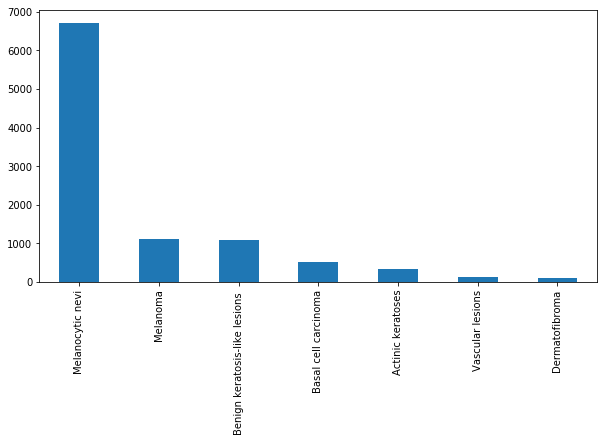

In [49]:
# The distribution of different cell types
# Source from the data contributor: https://www.kaggle.com/yuningalexliu/dermatology-image-classification

axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cell_type'].value_counts().plot(kind='bar', ax=axis)

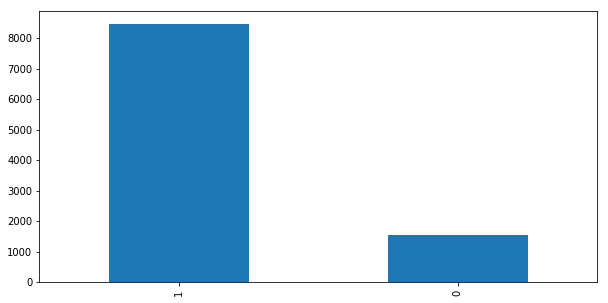

In [50]:
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cancerous_status'].value_counts().plot(kind='bar', ax=axis)

We can see from the graph above that "Melanocytic nevi" dominate other classes significantly which cause a problem of imbalanced data where Melanocytic nevi will affect the prediction of other skin cancer classes.

Reducing "Melanocytic nevi" data method

Source: https://www.kaggle.com/yuningalexliu/dermatology-image-classification

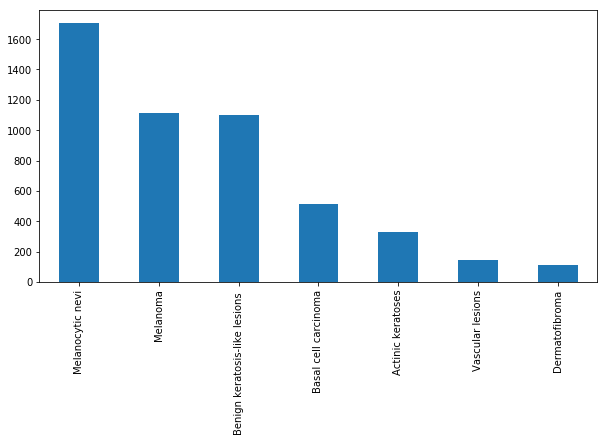

In [51]:
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 4].iloc[:5000].index)

# The new distribution of different cell types after reducing cell index '4'
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cell_type'].value_counts().plot(kind='bar', ax=axis)

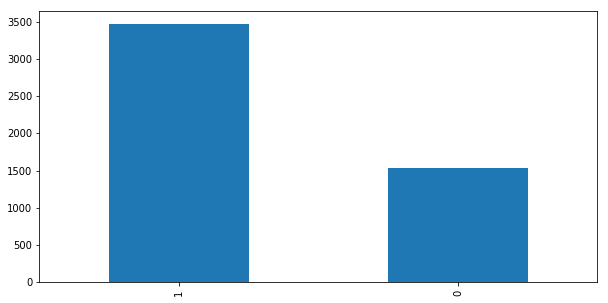

In [52]:
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cancerous_status'].value_counts().plot(kind='bar', ax=axis)

While these data indicates an imbalanced dataset, this is still better since data of "Melanocytic nevi" now does not dominate other skin cancer data too much.

In [53]:
#resizing images
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [54]:
target = skin_df['cancerous_status']

In [55]:
features = skin_df.drop(columns=['cancerous_status'],axis=1)

### Split the dataset into training data (80%) and testing data (20%)

In [56]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.20, random_state=42)

### Normalization

In [57]:
# Use only an image as a feature
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [58]:
# hot encoding
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

In [59]:
x_train = x_train.reshape(x_train.shape[0], 22500)
x_test = x_test.reshape(x_test.shape[0], 22500)

### Build Random Forest Classifer using Scikit-Learn

In [60]:
# Import Random Forest classifier from sklearn.ensemble package
from sklearn.ensemble import RandomForestClassifier
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

rf = RandomForestClassifier(n_estimators= 100, random_state = 42, max_depth=2, min_samples_split=0.1,
                                                min_samples_leaf=0.1, max_features=0.1, n_jobs = -1)
                    
# Train the model on training data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
# Model Accuracy, how often is the classifier correct?
new = metrics.accuracy_score(y_test, y_pred)
                    
print(" Accuracy: ", new)

 Accuracy:  0.7238285144566301
